In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import numpy as np

import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2

import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-28 15:14:49.700592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759072489.888436      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759072489.957195      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?





Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (30 points)
These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.

For the sake of this project, you can use GitHub to showcase your codebase. In the real world, versioning with GitHub is vital for collaboration. Sometimes Jupyter notebooks don’t seem particularly well-suited to versioning with GitHub due to hard-to-read diffs and the like. If you want to use this project as an opportunity to practice versioning with GitHub, consider something like the following: 
https://www.reviewnb.com
.

Quick look at Data

In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.shape

(7613, 5)

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.shape

(3263, 4)

In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<h1>Part 1 - Brief description of the problem and data </h1>

https://www.kaggle.com/competitions/nlp-getting-started

This project is centered around twitter and disaster detection. The goal is to predict if certain tweets are related to real disasters or not. The dataset contains 10,000 tweets (rows), which are split into training (train.csv) and test (test.csv) sets. The training data contains 5 columns (id, keyword, location, text and target) with the target being the label (1 for disaster and 0 for not disaster). The test data only contains 4 columns, with the label (target) being missing. We will be using Natural language processing to analyze and make predictions on the disaster target label.


<h1>Part 2 - Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data </h1>

We will first take a quick a big picture look at the data and then see if we can do some cleaning.
We will be using stopword to remove the commong words during preprocessing.
TF-IDF will help reflect the importance of a word by tokenizing the text. The TF-IDF score will also by calculated.

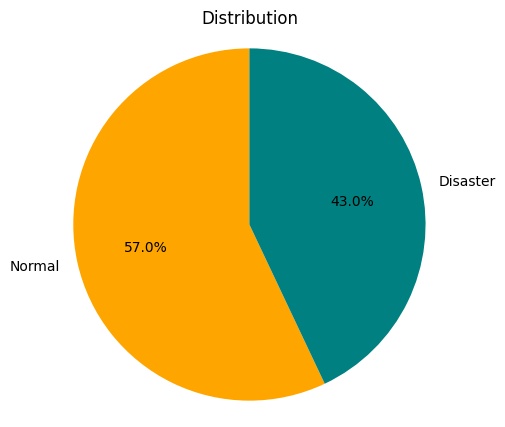

In [6]:
# Distribution of tweets
counts = train_df['target'].value_counts()
counts.index = ['Disaster' if i == 1 else 'Normal' for i in counts.index]

# Creating a pie chart
plt.figure(figsize=(5, 5))  # Set the size of the figure (optional)
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'teal'])
plt.title('Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Distribution appears relatively balanced.

In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


This quick skim lets us know there are null values in our data. We should check how many values are null. If there are not too many null values, we can simply delete them.

In [8]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

There are very few NULL values for keyword, but a lot for location. We can drop records for NULL keyboards, but that is not idael for location. We can replace the null values for location.

In [10]:
counts = train_df['location'].value_counts()
print(counts)


location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64


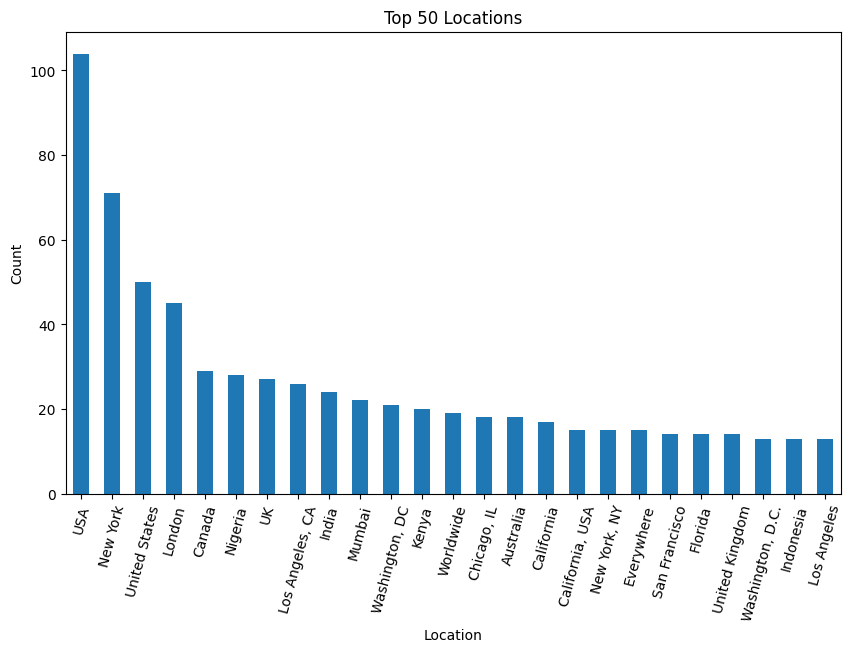

In [11]:
plt.figure(figsize=(10, 6))
train_df['location'].value_counts().head(25).plot(kind='bar')

plt.title('Top 50 Locations')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.show()

Looking at the locations count, it doesn't seem like it would be possible to put a common or random location. We will have to plug in a location like "unknown".

In [12]:
train_df = train_df[~train_df['keyword'].isna()].reset_index(drop=True)
train_df['location'] = train_df['location'].fillna('unknown')
train_df['location'] = train_df['location'].str.strip()
train_df.head()

,id,keyword,location,text,target
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
1,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
2,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
3,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
4,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


We can convert our text to lower case and also use stopwords to reduce noise and focus on meaningful words.

In [13]:
english_stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word not in english_stopwords]
    return ' '.join(filtered_tokens)  # Optionally join back into a string

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
print(train_df)

         id  keyword                       location  \
0        48   ablaze                     Birmingham   
1        49   ablaze  Est. September 2012 - Bristol   
2        50   ablaze                         AFRICA   
3        52   ablaze               Philadelphia, PA   
4        53   ablaze                     London, UK   
...     ...      ...                            ...   
7547  10830  wrecked                        unknown   
7548  10831  wrecked              Vancouver, Canada   
7549  10832  wrecked                         London   
7550  10833  wrecked                        Lincoln   
7551  10834  wrecked                        unknown   

                                                   text  target  \
0     @bbcmtd Wholesale Markets ablaze http://t.co/l...       1   
1     We always try to bring the heavy. #metal #RT h...       0   
2     #AFRICANBAZE: Breaking news:Nigeria flag set a...       1   
3                    Crying out for more! Set me ablaze       0   
4   

Now that the text is cleaned, let's take a quick look at the top meaningful words for both categories.

Processing target: 1


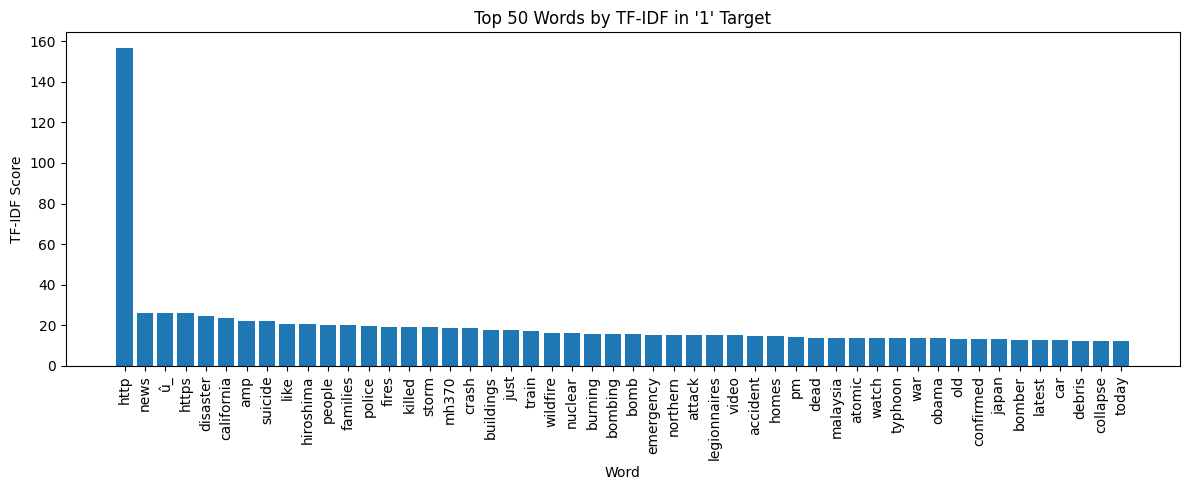

Processing target: 0


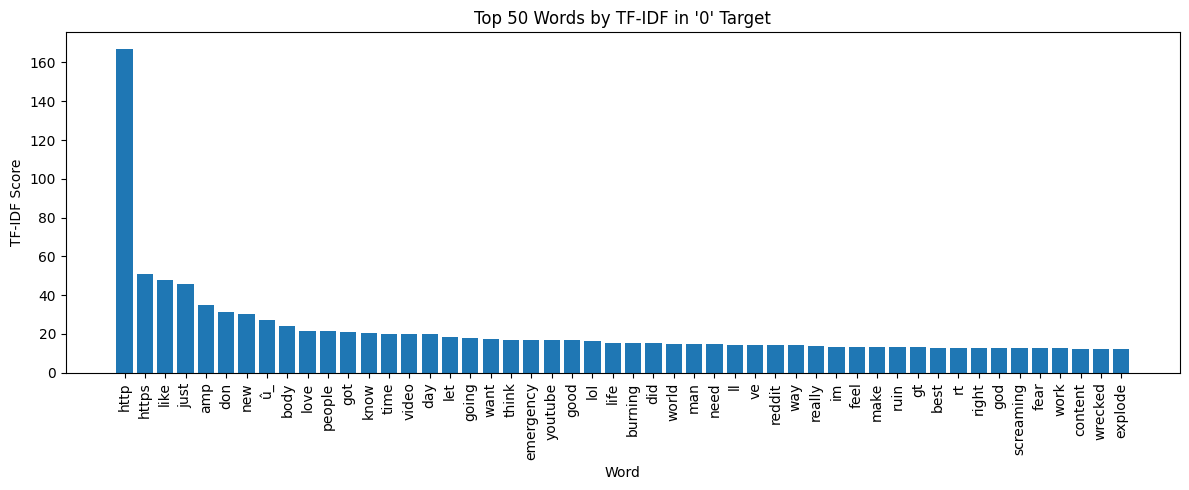

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
df_0 = train_df[train_df['target'] == 0].reset_index(drop=True)
df_1 = train_df[train_df['target'] == 1].reset_index(drop=True)
category_dfs = {
    '1': df_1,
    '0': df_0

}
n_to_plot = 50

for target, cat_df in category_dfs.items():
    print(f"Processing target: {target}")
    
    
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(cat_df['text'])

   
    feature_names = np.array(vectorizer.get_feature_names_out())
    tfidf_sums = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    
    top_indices = np.argsort(tfidf_sums)[::-1][:n_to_plot]
    top_words = feature_names[top_indices]
    top_scores = tfidf_sums[top_indices]

    
    plt.figure(figsize=(12, 5))
    plt.bar(top_words, top_scores)
    plt.xlabel("Word")
    plt.ylabel("TF-IDF Score")
    plt.title(f"Top {n_to_plot} Words by TF-IDF in '{target}' Target")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Using Tfid could be a good step in differentiating the targets.

<h1>Part 3: Model Architecture</h1>
Long Short-Term Memory)LSTM is a good choice for an RNN(Recurrent Neural Network) due to the nature of a tweet. 
LSTMs are good in Language modeling and translation and anomaly detection. 
A Bidirectional LSTM may also be good to in capturing past and future contect, but is more computationally expensive.
A stacked LSTM would be a good model candidate if tweets were longer and we had a larger dataset. The model could learn from hierchial representations where the first LSTM could capture word-level patterns, and the second level could capture sentence-level patterns. This is more prone to overfitting on small data.

Our embedding layer handles raw tokenized tweets instead of one-hot vectors, making it more efficient. 
The LSTM layer of 64 units learns sequential dependencies in the text.
64 hidden units balance overfitting risk with expressive power.
A single output neuron with Sigmoid is suitable for binary classification (disaster vs not disaster).
We use early stopping to prevent overfitting.


We first work on the embedding layer by tokenizing the text

In [15]:
max_words = 10000  # number of words to consider from the dataset
max_len   = 15  # sequences are padded/truncated to this length


Tokenize cleaned text and split the training and test data

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['clean_text'], train_df['target'], test_size=0.2, random_state=42)

# Tokenizing text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_valid = tokenizer.texts_to_sequences(X_valid)

Let's take a look at the sequence lengths and determine a "max length"

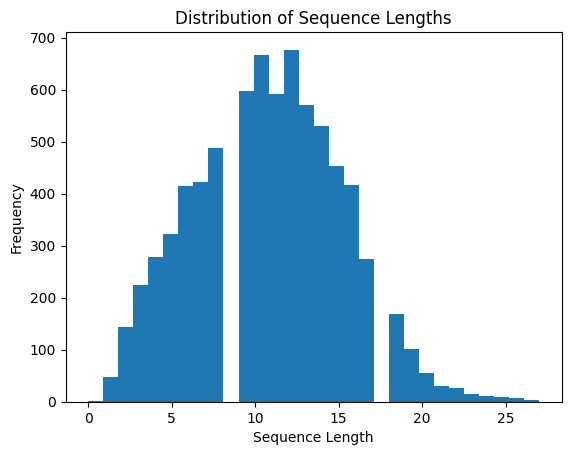

90th percentile: 16.0


In [17]:
sequence_lengths = [len(seq) for seq in tokenizer.texts_to_sequences(train_df['clean_text'])]

# Plotting the distribution
plt.hist(sequence_lengths, bins=30)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determining a suitable `maxlen` based on percentile
import numpy as np
print("90th percentile:", np.percentile(sequence_lengths, 90))

In [18]:
X_train = pad_sequences(X_train, maxlen=15)
X_valid = pad_sequences(X_valid, maxlen=15)

Do a quick run just to check that the model is working and is somewhat accurate

In [19]:
model_LSTM = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_shape=(max_len,)),
    LSTM(64),  # Single LSTM layer
    Dense(1, activation='sigmoid')
])
custom_adam = Adam(learning_rate=0.0001)

model_LSTM.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=True)

history_LSTM = model_LSTM.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=128, callbacks=[early_stop])

loss, accuracy = model_LSTM.evaluate(X_valid, y_valid)
print()
print("Validation accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1759072728.796313      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/20


I0000 00:00:1759072733.050292     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5715 - loss: 0.6886 - val_accuracy: 0.6069 - val_loss: 0.6664
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6262 - loss: 0.6559 - val_accuracy: 0.6254 - val_loss: 0.6397
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6672 - loss: 0.6297 - val_accuracy: 0.6618 - val_loss: 0.6258
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6839 - loss: 0.6096 - val_accuracy: 0.6777 - val_loss: 0.6104
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7096 - loss: 0.5841 - val_accuracy: 0.7015 - val_loss: 0.5852
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7504 - loss: 0.5387 - val_accuracy: 0.7651 - val_loss: 0.5247
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8229 - loss: 0.4361 - val_accuracy: 0.8008 - val_loss: 0.4690
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8620 - loss: 0.3453 - val_accuracy: 0.8034 - val_loss: 0.4573
Ep

<h1>Part 3 Results and Analysis</h1>
We achieved decent accuracy on our initial test and verified that the model is working.
Our best validation accuracy was 0.803. Let's plot the accuracy and loss plots

<Figure size 640x480 with 0 Axes>

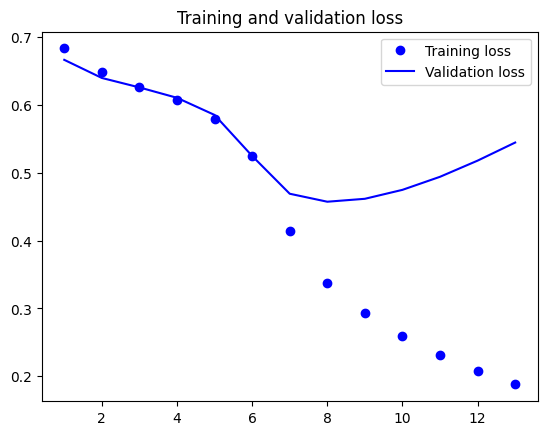

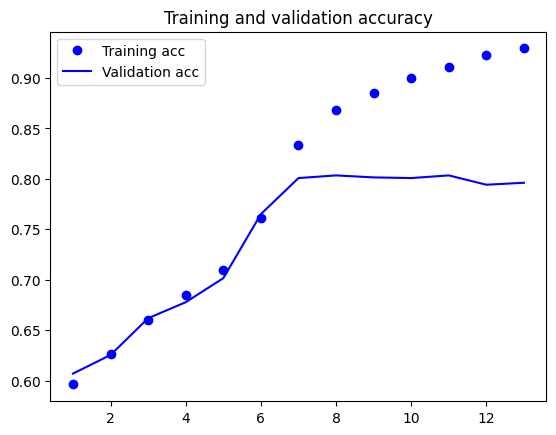

<Figure size 640x480 with 0 Axes>

In [27]:
history=history_LSTM
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

 We will now tune some hyperparameters in the LSTM model (learning rate, LSTM units)

In [20]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
    
    # LSTM layer, we are tuning the lstm units here
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    model.add(LSTM(units=lstm_units))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Learning rate tuning
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Setup tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/kaggle/working/',
    project_name='lstm_tuning'
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Run search
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             epochs=10,
             batch_size=128,
             callbacks=[early_stop],
             verbose=1)

# Best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Save best model
best_model.save("best_lstm_model.h5")

# Print best hyperparameters
print("Best learning rate:", best_hps.get('learning_rate'))
print("Best LSTM units:", best_hps.get('lstm_units'))


Trial 9 Complete [00h 00m 06s]
val_accuracy: 0.7928524017333984

Best val_accuracy So Far: 0.8093977570533752
Total elapsed time: 00h 01m 00s
Best learning rate: 0.0001
Best LSTM units: 64


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Let's use our best fit and use that model for prediction on test data.

In [23]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
test_df.shape

(3263, 4)

In [24]:
#test_df = test_df[~test_df['keyword'].isna()].reset_index(drop=True)
test_df['location'] = test_df['location'].fillna('unknown')
test_df['location'] = test_df['location'].str.strip()
english_stopwords = set(stopwords.words('english'))
test_df['clean_text'] = test_df['text'].apply(preprocess_text)
test_sequences = tokenizer.texts_to_sequences(test_df['clean_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len)
test_predictions = best_model.predict(test_padded_sequences)
test_df['target'] = (test_predictions > 0.5).astype(int)
submission_df = test_df[['id', 'target']]
print(submission_df)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
         id  target
0         0       0
1         2       0
2         3       1
3         9       0
4        11       1
...     ...     ...
3258  10861       0
3259  10865       1
3260  10868       1
3261  10874       1
3262  10875       0

[3263 rows x 2 columns]


In [25]:
submission_df.to_csv('submission.csv', index=False)

<h1>Conclusion</h1>

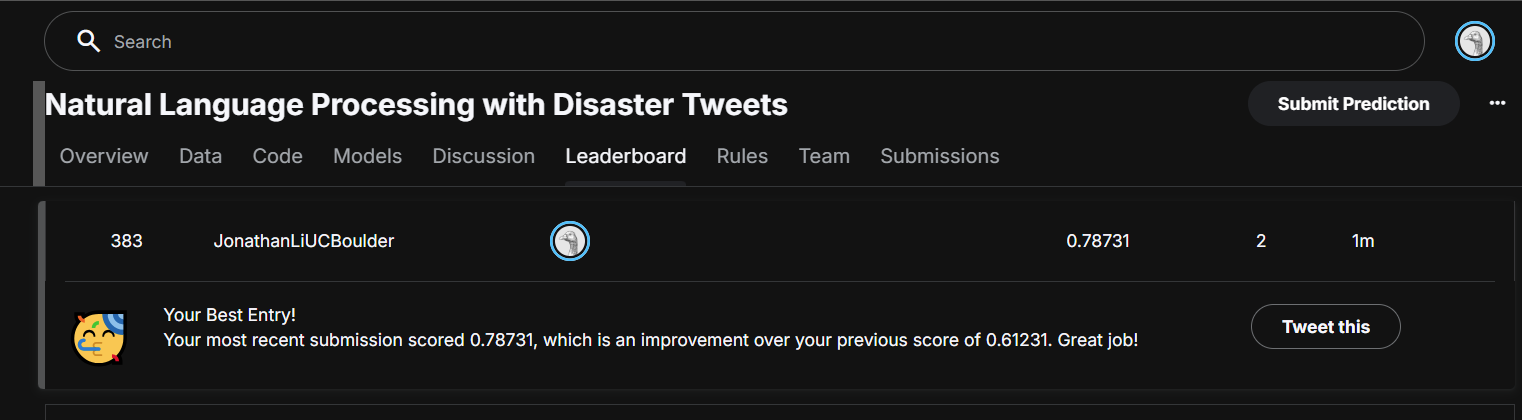

We achieved an accuracy of 0.78731!
There are some things that could improve this model in the future. 
I would probably test Stacked LSTM to learn hierarchical features (word-level patterns, sentence-level patterns), but the concern is overfitting due to smaller dataset. 
I would also consider adding a dropout to prevent overfitting, but the convergence may be slower. Using an attention mechanism would also help by focusing on keywords such as urgent, emergency, fire etc.
THe data preprocessing could also use some improvements. We could clean the data more to remove URLs and hangle hashtags or mentions. Emojis could also be mapped to sentiment tokens.

References:
https://keras.io/api/layers/recurrent_layers/lstm/
https://www.nltk.org/api/nltk.tokenize.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
https://www.kaggle.com/competitions/nlp-getting-started
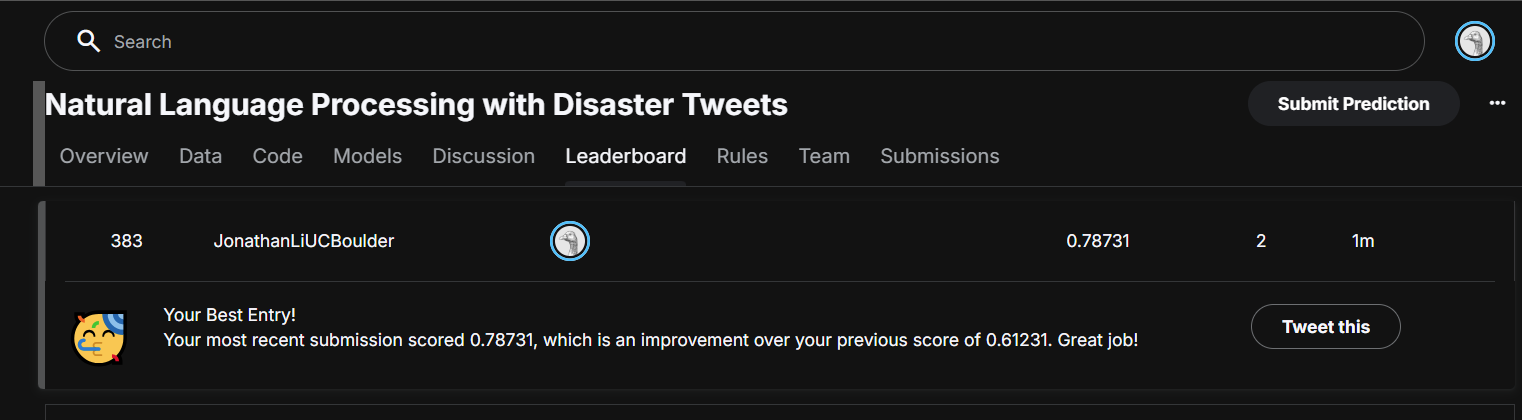